#Importing Libraries

In [1]:
import os
#pip install opencv-python
import cv2 #open cv 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import skimage 
from skimage.io import imread,imshow
from skimage import io,color
from skimage.color import rgb2gray
from skimage.transform import  resize
from sklearn.metrics import mean_squared_error
# import scikitplot as skplt
from sklearn import datasets, metrics, model_selection,preprocessing
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
from keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,BatchNormalization
import pandas as pd
import sklearn
# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import random

#Loading and Preprocessing the data

Mounting to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create 2 empty list: one to hold the images and another one to assign the corresponding label to them 
After reading and labelling each image, transform from rgb to gray scale and resize them to 28*28, that is commonly suitable size for the training images as an input to the machine learning model 

In [4]:
def load_images(imgs_path):
  all_images=[]
  all_labels=[]
  letters=[1,2,3,4,6]
  for i in range(5):
      path=imgs_path[i]
      for file in os.listdir(path):
          img=imread(os.path.join(path,file))                 # Reading te image
          # img_gray=rgb2gray(img)                                 # change the image from rgb to gray
          img_resized=resize(img,(64,64))          #resize the image to 28*28
          all_labels.append(letters[i])                             
          all_images.append(img_resized)
      
  return np.array(all_images),np.array(all_labels).astype(float)

Reading the path of the directory from the drive

In [5]:
path_train="/content/drive/MyDrive/Computer vision assignment3/training/"
imgs_path_training=[path_train+"1/",path_train+"2/",path_train+ "3/",path_train+ "4/",path_train+ "6/"]

path_test="/content/drive/MyDrive/Computer vision assignment3/testing/"
imgs_path_testing=[path_test+"1/",path_test+"2/",path_test+ "3/",path_test+ "4/",path_test+ "6/"]

In [6]:
train_images,train_labels=load_images(imgs_path_training)
test_images,test_labels=load_images(imgs_path_testing)

changing the images and labels lists to numpy array

In [7]:
train_images=np.array(train_images)
print("size of the training images",train_images.shape)
train_labels=np.array(train_labels)
np.unique(train_labels,return_counts=True)

size of the training images (900, 64, 64, 3)


(array([1., 2., 3., 4., 6.]), array([180, 180, 180, 180, 180]))

In [8]:
X_test=np.array(test_images)
print("size of the testing images",test_images.shape)
y_test=np.array(test_labels)
np.unique(test_labels,return_counts=True)

size of the testing images (100, 64, 64, 3)


(array([1., 2., 3., 4., 6.]), array([20, 20, 20, 20, 20]))

the image label is: 1.0


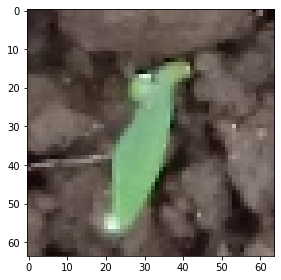

In [9]:
imshow(train_images[79])        #displaying the image of index 79 and it's label 
print("the image label is:", train_labels[79] ) 

##Training and Validation


Let's split into training images and test images.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=1.0/7,random_state=41)
print("shape of training data",X_train.shape)
print("shape of validation data",X_valid.shape)

shape of training data (771, 64, 64, 3)
shape of validation data (129, 64, 64, 3)


#Helper Functions

In [161]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = [1,2,3,4,6]

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    


In [162]:
def reset_graph(seed=41):
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed) 

In [257]:
def plot_loss_history(history):

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [258]:
def plot_accuracy_history(history):

  k = ''
  if 'accuracy' in history.history :
      k = 'accuracy'    

  if 'acc' in history.history :
      k = 'acc'
      
  if k != '' :    
      plt.plot(history.history[k])
      plt.plot(history.history['val_'+k])
      plt.title('Model Accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['train', 'validation'], loc='upper left')
      plt.show()


# 3.1 Basic Transfer Learning:Classification Network
Import only the first two blocks of the VGG net and put our own classification layer on top. We will keep VGG net fix (freeze the first 2 blocks and just train ourtop layers.

Since our true labels is 1,2,3,4,6 we are going to mab them to 0,1,2,3,4 and changing them to categories as we do in labelEncoder, but here we will try keras.utils.to_categorical

In [246]:
mapping = {1:0, 2:1, 3:2, 4:3, 6:4}
y_train_class = np.array([mapping[key] for key in y_train])
y_valid_class = np.array([mapping[key] for key in y_valid])
y_test_class = np.array([mapping[key] for key in y_test])

nClasses = 5
# Use Keras' handy utils
y_train_k = tensorflow.keras.utils.to_categorical(y_train_class, num_classes=nClasses)
y_valid_k = tensorflow.keras.utils.to_categorical(y_valid_class, num_classes=nClasses)
y_test_k = tensorflow.keras.utils.to_categorical(y_test_class, num_classes=nClasses)


##Model Architecture

---

Here we took the output of layer 6 from the VGG16 net and freeze it's weight, then we added a convolution layer with 64 filters and same padding then we added w maxpooling layer to decrease the output features map then we flatten the feature map to input it to the fully connected layer(MLP), the output layer will contain 5 classes and we will use LeakyRelu as Softmax as our acttivation function.

In [247]:
from tensorflow.keras.applications import VGG16
 
vgg_model_CLASS = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64,64, 3))

for layer in vgg_model_CLASS.layers:
    layer.trainable = False

reset_graph(seed=9)

# last layers output
y = vgg_model_CLASS.layers[6].output
# Block 3
y = Conv2D(64, (3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D((2, 2), strides=(2, 2))(y)

y = Flatten(name='flatten')(y)
y = Dense(32, activation='relu')(y)
y = Dense(5,activation='softmax')(y)
from tensorflow.keras.models import Model
vgg_model_classification = Model(inputs=vgg_model_CLASS.input, outputs=y)

In [248]:
print(vgg_model_classification.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

## Model training

In [249]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',patience=3)
reset_graph(seed=9)

vgg_model_classification.compile(loss='categorical_crossentropy', 
                           optimizer='Adam', 
                           metrics=['accuracy'])

history_classification = vgg_model_classification.fit(X_train, y_train_k, batch_size=16, epochs=15, verbose=1, 
                                                      validation_data=(X_valid, y_valid_k))

Epoch 1/15
49/49 [==============================] - 2s 19ms/step - loss: 3.0281 - accuracy: 0.2049 - val_loss: 1.6089 - val_accuracy: 0.2171
Epoch 2/15
49/49 [==============================] - 1s 12ms/step - loss: 1.6111 - accuracy: 0.2075 - val_loss: 1.6407 - val_accuracy: 0.1705
Epoch 3/15
49/49 [==============================] - 1s 12ms/step - loss: 1.5966 - accuracy: 0.2646 - val_loss: 1.5967 - val_accuracy: 0.3101
Epoch 4/15
49/49 [==============================] - 1s 12ms/step - loss: 1.5160 - accuracy: 0.2892 - val_loss: 1.7576 - val_accuracy: 0.1860
Epoch 5/15
49/49 [==============================] - 1s 12ms/step - loss: 1.4385 - accuracy: 0.3437 - val_loss: 1.7769 - val_accuracy: 0.2093
Epoch 6/15
49/49 [==============================] - 1s 12ms/step - loss: 1.3402 - accuracy: 0.4293 - val_loss: 1.6131 - val_accuracy: 0.2171
Epoch 7/15
49/49 [==============================] - 1s 13ms/step - loss: 1.2811 - accuracy: 0.4734 - val_loss: 1.7140 - val_accuracy: 0.2093
Epoch 8/15
49

In [250]:
#training
classification_trainpredict_prob = vgg_model_classification.predict(X_train)
clasification_train_pred = classification_trainpredict_prob.argmax(axis=-1)
#validation
classification_validpredict_prob = vgg_model_classification.predict(X_valid)
clasification_valid_pred = classification_validpredict_prob.argmax(axis=-1)
#testing
classification_testpredict_prob = vgg_model_classification.predict(X_test)
clasification_test_pred = classification_testpredict_prob.argmax(axis=-1)

##Evaluation Metrics

**Classification Report**

In [251]:
print("Classification Report of Validation data:\n\n",classification_report(y_train_class,clasification_train_pred))

Classification Report of Validation data:

               precision    recall  f1-score   support

           0       1.00      0.98      0.99       168
           1       0.88      1.00      0.94       152
           2       0.98      0.88      0.93       147
           3       1.00      0.98      0.99       155
           4       0.97      0.99      0.98       149

    accuracy                           0.97       771
   macro avg       0.97      0.97      0.97       771
weighted avg       0.97      0.97      0.97       771



In [252]:
print("Classification Report of Validation data:\n\n",classification_report(y_valid_class,clasification_valid_pred))

Classification Report of Validation data:

               precision    recall  f1-score   support

           0       0.28      0.42      0.33        12
           1       0.36      0.36      0.36        28
           2       0.18      0.09      0.12        33
           3       0.34      0.48      0.40        25
           4       0.35      0.35      0.35        31

    accuracy                           0.32       129
   macro avg       0.30      0.34      0.31       129
weighted avg       0.30      0.32      0.30       129



In [253]:
print("Classification Report of testing data:\n\n",classification_report(y_test_class,clasification_test_pred))

Classification Report of testing data:

               precision    recall  f1-score   support

           0       0.52      0.55      0.54        20
           1       0.32      0.60      0.42        20
           2       0.31      0.20      0.24        20
           3       0.38      0.15      0.21        20
           4       0.43      0.45      0.44        20

    accuracy                           0.39       100
   macro avg       0.39      0.39      0.37       100
weighted avg       0.39      0.39      0.37       100



**Confusion Matrix**

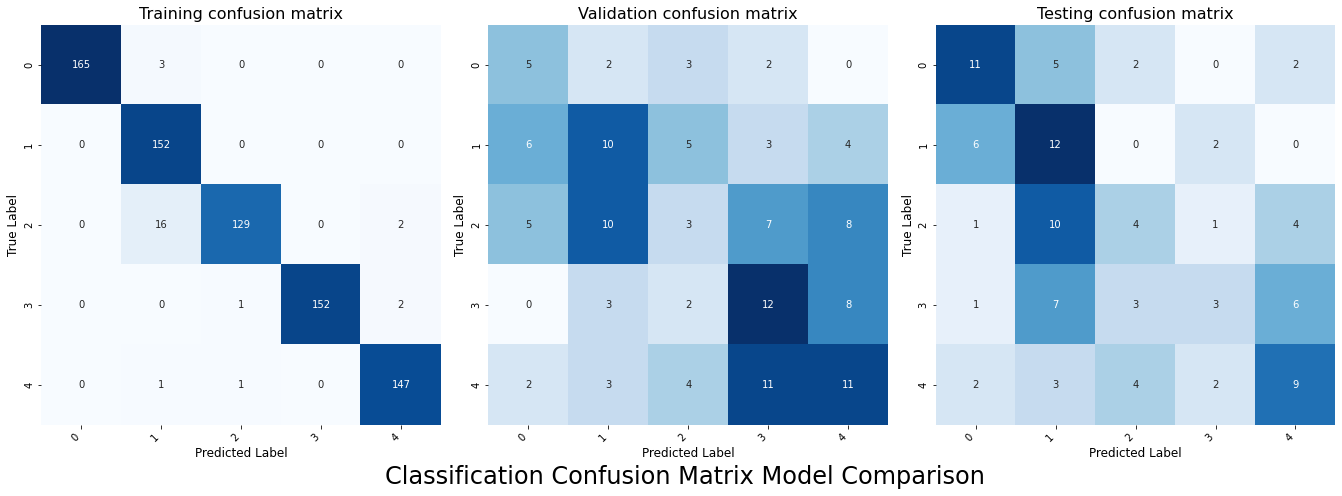

In [254]:
fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 5))

plot_heatmap(y_train_class,clasification_train_pred,[0,1,2,3,4], ax1, title="Training confusion matrix")  
plot_heatmap(y_valid_class,clasification_valid_pred,[0,1,2,3,4], ax2, title="Validation confusion matrix")    
plot_heatmap(y_test_class,clasification_test_pred,[0,1,2,3,4], ax3, title="Testing confusion matrix")   

fig.suptitle("Classification Confusion Matrix Model Comparison", fontsize=24)
fig. tight_layout(pad=7.0)
fig.subplots_adjust(top=3.00)
plt.show()

**History Visualization**

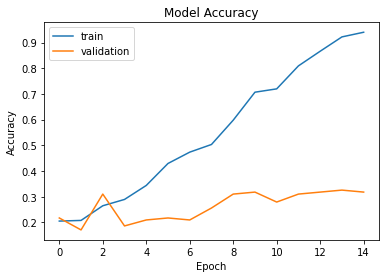

In [255]:
plot_accuracy_history(history_classification)

**Loss**
Source: Keras manual

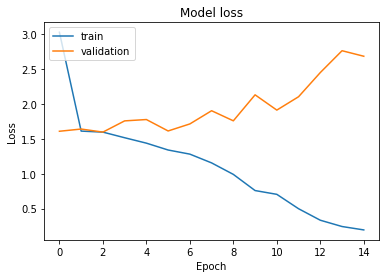

In [259]:
plot_loss_history(history_classification)

# 3.2 Basic Transfer Learning: Regression Network
Import only the first two blocks of the VGG net and put our own classification layer on top. We will keep VGG net fix (freeze the first 2 blocks and just train ourtop layers.

##Model architecture

---
Here we took again the output of layer 6 from the VGG16 net and freeze it's weight, then we added a convolution layer with 64 filters and same padding then we added w maxpooling layer to decrease the output features map then we flatten the feature map to input it to the fully connected layer(MLP), the output layer will contain only **one** class and we will use LeakyRelu as our activation function and put a threshold function to round our predictions in order to print the confusion matrix, classification report.( a tricky way to compare between it and the classification model)

In [176]:
from tensorflow.keras.applications import VGG16
vgg_model_regr = VGG16(weights='imagenet',
                  include_top=False,
                  classifier_activation="linear",
                  input_shape=(64,64, 3))

reset_graph(seed=9)
for layer in vgg_model_regr.layers:
    layer.trainable = False

# last layers output
x = vgg_model_regr.layers[6].output

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = Flatten(name='flatten')(x)
x = Dense(32, activation='relu')(x)

x = Dense(1,activation=keras.layers.LeakyReLU(alpha=0.1))(x)
# x = Dense(1,activation='relu6')(x)

from tensorflow.keras.models import Model
vgg_model_regression = Model(inputs=vgg_model_regr .input, outputs=x)


**note** I tried to use **relu6** as activation function in the output layer and tried different combinations to have float numbers between 0 and 6, However; the model output is always one class only.

In [177]:
print(vgg_model_regression.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

## Model Training

In [178]:
reset_graph(seed=9)
vgg_model_regression.compile(loss= "mean_squared_error" , optimizer="Adam", metrics=["mean_squared_error"])
history_regression = vgg_model_regression.fit(X_train, y_train, batch_size=16, epochs=15, verbose=1,  validation_data=(X_valid, y_valid))

Epoch 1/15
49/49 [==============================] - 1s 17ms/step - loss: 26.9369 - mean_squared_error: 26.9369 - val_loss: 3.1964 - val_mean_squared_error: 3.1964
Epoch 2/15
49/49 [==============================] - 1s 12ms/step - loss: 2.9603 - mean_squared_error: 2.9603 - val_loss: 2.5070 - val_mean_squared_error: 2.5070
Epoch 3/15
49/49 [==============================] - 1s 12ms/step - loss: 2.5570 - mean_squared_error: 2.5570 - val_loss: 2.1984 - val_mean_squared_error: 2.1984
Epoch 4/15
49/49 [==============================] - 1s 11ms/step - loss: 2.4178 - mean_squared_error: 2.4178 - val_loss: 2.1525 - val_mean_squared_error: 2.1525
Epoch 5/15
49/49 [==============================] - 1s 11ms/step - loss: 1.9996 - mean_squared_error: 1.9996 - val_loss: 2.2158 - val_mean_squared_error: 2.2158
Epoch 6/15
49/49 [==============================] - 1s 12ms/step - loss: 1.7590 - mean_squared_error: 1.7590 - val_loss: 2.0504 - val_mean_squared_error: 2.0504
Epoch 7/15
49/49 [==============

In [179]:
#training
train_pred= vgg_model_regression.predict(X_train)
print("maximum values of  train predications=",np.max(train_pred))
print("minimum values of  train predications=",np.min(train_pred))
#validation
valid_pred= vgg_model_regression.predict(X_valid)
print("maximum values of valid predications=",np.max(valid_pred))
print("minimum values of valid predications=",np.min(valid_pred))
#testing
test_pred= vgg_model_regression.predict(X_test)
print("maximum values of test predications=",np.max(test_pred))
print("minimum values of test predications=",np.min(test_pred))

maximum values of  train predications= 7.2605553
minimum values of  train predications= -0.070749156
maximum values of valid predications= 7.92691
minimum values of valid predications= 0.09936863
maximum values of test predications= 6.282753
minimum values of test predications= 0.25443262


**Mean squared error**

In [192]:
print("mean_squared_error of regression on training" ,mean_squared_error(y_train,train_pred))

mean_squared_error of regression on training 0.7327547314998774


In [191]:
print("mean_squared_error of regression on validation" ,mean_squared_error(y_valid,valid_pred))

mean_squared_error of regression on validation 1.8359946877242421


In [180]:
print("mean_squared_error of regression on testing" ,mean_squared_error(y_test,test_pred))

mean_squared_error of regression problem 1.8010248610634276


**History Visualization**

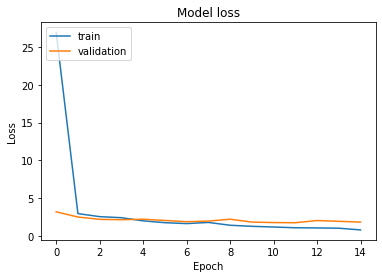

In [260]:
plot_loss_history(history_regression)

## Additional Evaluation metrics

---Now let's print our classification Report and Visualize the confusion matrix and plot the training loss curve by rounding our predictions and change our problem to be treated as classification one.



A threshold function to round the values between 0 and 6 

In [181]:
def round_float_values(pred):
  rounded_Reg_predictions=[]
  for i in range(len(pred)):
    if pred[i][0] <=1:
      rounded_Reg_predictions.append(1)
    elif pred[i][0] >=4.5 :
      rounded_Reg_predictions.append(6)
    else:
      rounded_Reg_predictions.append(np.round(pred[i][0]))
  return rounded_Reg_predictions

In [182]:
train_rounded_pred=round_float_values(train_pred)
valid_rounded_pred=round_float_values(valid_pred)
test_rounded_pred=round_float_values(test_pred)

In [183]:
np.unique(train_rounded_pred,return_counts=True)

(array([1., 2., 3., 4., 6.]), array([ 80, 135, 188, 187, 181]))

In [184]:
np.unique(valid_rounded_pred,return_counts=True)

(array([1., 2., 3., 4., 6.]), array([ 3, 14, 38, 40, 34]))

In [185]:
np.unique(test_rounded_pred,return_counts=True)

(array([1., 2., 3., 4., 6.]), array([ 8, 19, 26, 27, 20]))

**Classification Report**

In [186]:
print("Classification Report of Training  data:\n\n",classification_report(y_train,train_rounded_pred))

Classification Report of Training  data:

               precision    recall  f1-score   support

         1.0       0.94      0.45      0.60       168
         2.0       0.39      0.34      0.36       152
         3.0       0.39      0.50      0.44       147
         4.0       0.51      0.61      0.56       155
         6.0       0.71      0.86      0.78       149

    accuracy                           0.55       771
   macro avg       0.59      0.55      0.55       771
weighted avg       0.59      0.55      0.55       771



In [187]:
print("Classification Report of Validation data:\n\n",classification_report(y_valid,valid_rounded_pred))

Classification Report of Validation data:

               precision    recall  f1-score   support

         1.0       1.00      0.25      0.40        12
         2.0       0.36      0.18      0.24        28
         3.0       0.34      0.39      0.37        33
         4.0       0.28      0.44      0.34        25
         6.0       0.50      0.55      0.52        31

    accuracy                           0.38       129
   macro avg       0.49      0.36      0.37       129
weighted avg       0.43      0.38      0.37       129



In [188]:
print("Classification Report of testing data:\n\n",classification_report(y_test,test_rounded_pred))

Classification Report of testing data:

               precision    recall  f1-score   support

         1.0       0.50      0.20      0.29        20
         2.0       0.32      0.30      0.31        20
         3.0       0.31      0.40      0.35        20
         4.0       0.41      0.55      0.47        20
         6.0       0.55      0.55      0.55        20

    accuracy                           0.40       100
   macro avg       0.42      0.40      0.39       100
weighted avg       0.42      0.40      0.39       100



**Confusion matrix**

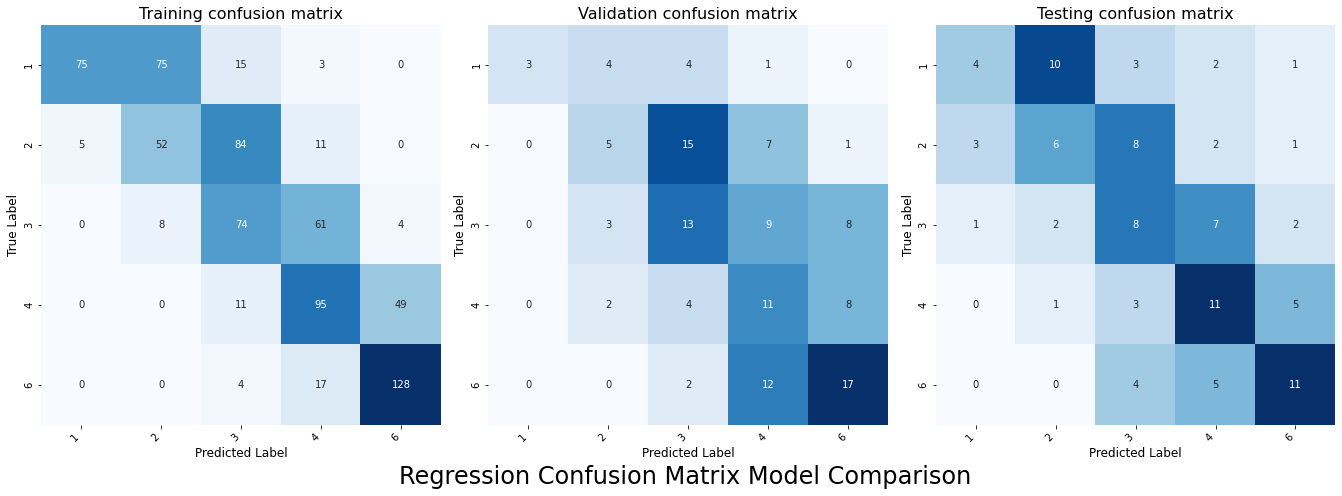

In [189]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 5))

plot_heatmap(y_train,train_rounded_pred,[1,2,3,4,6], ax1, title="Training confusion matrix")    
plot_heatmap(y_valid,valid_rounded_pred,[1,2,3,4,6], ax2, title="Validation confusion matrix")    
plot_heatmap(y_test,test_rounded_pred,[1,2,3,4,6], ax3, title="Testing confusion matrix")   

fig.suptitle("Regression Confusion Matrix Model Comparison", fontsize=24)
fig. tight_layout(pad=7.0)
fig.subplots_adjust(top=3.00)
plt.show()

#3.3 Discussion

To compare the models' performance based on the learning curve (loss curve of training vs validation)

We have put the same architecture nearly for the two models except for the output layer in each and trained using the same optimizers and for the same number of epochs.

**Regression Model** 

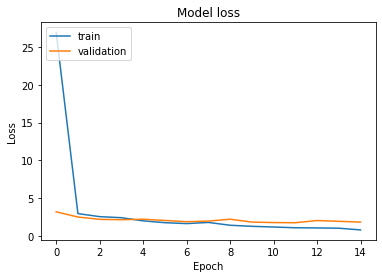


As we can see from the graph, even though the loss between the validation and trainig set is very small and that's good.

 The train curve is still going down, so maybe if we increase the number of epochs, the loss decreases. while the validation curve is almost not changing, 

 No overfitting here because the difference between the two curves is quite small, however, the model may be underfitting (not able to learn efficiently).

**Classification Model**



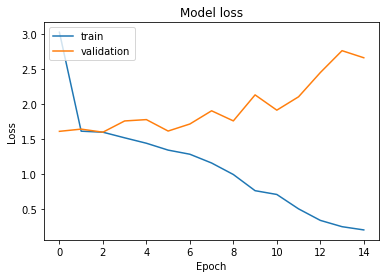


In this graph, we can see that the validation loss is much greater than the training loss and that represents overfitting ( the model is performing good on the training data, but not able to generalize.

**Better Model**

Now,to choose the model that performs better for our problem, I'll go for the classification model and that's because,the training accuracy for classification is 97% and for the regression is 55%, and here eventhough the classification model is overfitting, we might decrease this by regularization and augmentation. while the regression model seems to be underfitting and not able to understand properly our problem( maybe this could be solved by increasing the number of epochs!!!!, However we are stuck now with limited computational power.)




# 4 Regularization of te Classification Model


---


Since we have a dataset of limited size, our model is overfitting, performing good on the  training data but, they don’t generalize to data that has not been seen during training.

Fortunately, with regularization techniques, it’s possible to reduce overfitting, we will explore Dropout, batch normalization and l1 and l2 

 the idea behind **Dropouts** is to break up these conspiracies, we randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust.

**Batch normalization**  is a layer that allows every layer of the network to do learning more independently. It is used to normalize the output of the previous layers. The activations scale the input layer in normalization. Using batch normalization learning becomes efficient also it can be used as regularization to avoid overfitting of the model.

A regression model that uses **L1 regularization** technique is called Lasso Regression which adds “absolute value of magnitude” of coefficient as penalty term to the loss function, Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features.

##Model Architecture

Here, I tried different combinations of regularization in different positions and finally sticked with a **batch normalization** layer before the convolution layer to normaliza the input feature map that enters it and and **L1_regularization** in the fully connected later(dense layer). Botth methods together help the model to perform better on te test data nd decreases the difference in loss between train and validation data

In [443]:
reset_graph(9)
vgg_model_CLASS_reg = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64,64, 3))

for layer in vgg_model_CLASS_reg.layers:
    layer.trainable = False

# last layers output
d = vgg_model_CLASS_reg.layers[6].output
# Block 3
d = BatchNormalization(axis=1)(d)
d = Conv2D(64, (3, 3), activation='relu' ,padding='same')(d)

d = MaxPooling2D((2, 2), strides=(2, 2))(d)

d = Flatten(name='flatten')(d)

d = Dense(64, activation='relu' ,kernel_regularizer='l1')(d)

d = Dense(5,  activation= 'softmax' )(d)

from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

vgg_model_classification_reg = Model(inputs=vgg_model_CLASS_reg.input, outputs=d)

In [444]:
print(vgg_model_classification.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

## Model Training

In [445]:
reset_graph(9)
vgg_model_classification_reg.compile(loss='categorical_crossentropy', 
                           optimizer='Adam', 
                           metrics=['accuracy'])

history_classification_reg = vgg_model_classification_reg.fit(X_train, y_train_k, batch_size=16, epochs=15, verbose=1, 
                                                              validation_data=(X_valid, y_valid_k))

Epoch 1/15
49/49 [==============================] - 2s 20ms/step - loss: 26.7100 - accuracy: 0.2387 - val_loss: 9.7302 - val_accuracy: 0.2558
Epoch 2/15
49/49 [==============================] - 1s 14ms/step - loss: 5.6598 - accuracy: 0.4112 - val_loss: 3.5870 - val_accuracy: 0.2248
Epoch 3/15
49/49 [==============================] - 1s 13ms/step - loss: 2.6886 - accuracy: 0.4553 - val_loss: 2.5530 - val_accuracy: 0.3566
Epoch 4/15
49/49 [==============================] - 1s 13ms/step - loss: 2.1281 - accuracy: 0.5019 - val_loss: 2.1921 - val_accuracy: 0.3566
Epoch 5/15
49/49 [==============================] - 1s 13ms/step - loss: 1.9582 - accuracy: 0.5616 - val_loss: 2.4419 - val_accuracy: 0.3023
Epoch 6/15
49/49 [==============================] - 1s 13ms/step - loss: 1.9030 - accuracy: 0.5707 - val_loss: 2.3283 - val_accuracy: 0.4419
Epoch 7/15
49/49 [==============================] - 1s 13ms/step - loss: 1.7929 - accuracy: 0.6420 - val_loss: 2.3099 - val_accuracy: 0.3566
Epoch 8/15
4

In [446]:
#training
classification_trainpredict_prob_reg = vgg_model_classification_reg.predict(X_train)
clasification_train_pred_reg = classification_trainpredict_prob_reg.argmax(axis=-1)
#validation
classification_validpredict_prob_reg = vgg_model_classification_reg.predict(X_valid)
clasification_valid_pred_reg = classification_validpredict_prob_reg.argmax(axis=-1)
#testing
classification_testpredict_prob_reg = vgg_model_classification_reg.predict(X_test)
clasification_test_pred_reg = classification_testpredict_prob_reg.argmax(axis=-1)

##Evaluation matrix

**Classification Report**

In [447]:
print("Classification Report of Training data:\n\n",classification_report(y_train_class,clasification_train_pred_reg ))

Classification Report of Training data:

               precision    recall  f1-score   support

           0       0.91      0.98      0.94       168
           1       0.71      0.97      0.82       152
           2       0.92      0.73      0.82       147
           3       0.98      0.76      0.86       155
           4       0.96      0.93      0.94       149

    accuracy                           0.88       771
   macro avg       0.90      0.88      0.88       771
weighted avg       0.90      0.88      0.88       771



In [448]:
print("Classification Report of Validation data:\n\n",classification_report(y_valid_class,clasification_valid_pred_reg ))

Classification Report of Validation data:

               precision    recall  f1-score   support

           0       0.40      0.83      0.54        12
           1       0.36      0.54      0.43        28
           2       0.38      0.27      0.32        33
           3       0.29      0.20      0.24        25
           4       0.67      0.45      0.54        31

    accuracy                           0.41       129
   macro avg       0.42      0.46      0.41       129
weighted avg       0.43      0.41      0.40       129



In [449]:
print("Classification Report of testing data:\n\n",classification_report(y_test_class,clasification_test_pred_reg ))

Classification Report of testing data:

               precision    recall  f1-score   support

           0       0.58      0.95      0.72        20
           1       0.44      0.55      0.49        20
           2       0.29      0.10      0.15        20
           3       0.33      0.25      0.29        20
           4       0.55      0.55      0.55        20

    accuracy                           0.48       100
   macro avg       0.44      0.48      0.44       100
weighted avg       0.44      0.48      0.44       100



**Confusion matrix**

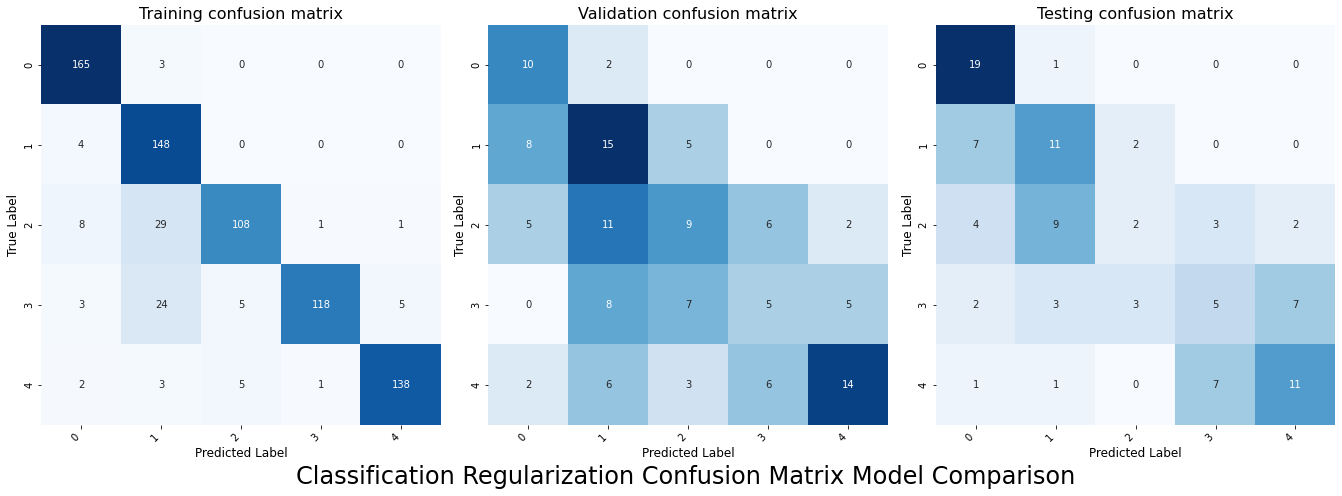

In [450]:
fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 5))

plot_heatmap(y_train_class,clasification_train_pred_reg ,[0,1,2,3,4], ax1, title="Training confusion matrix")  
plot_heatmap(y_valid_class,clasification_valid_pred_reg ,[0,1,2,3,4], ax2, title="Validation confusion matrix")    
plot_heatmap(y_test_class,clasification_test_pred_reg ,[0,1,2,3,4], ax3, title="Testing confusion matrix")   

fig.suptitle("Classification Regularization Confusion Matrix Model Comparison", fontsize=24)
fig. tight_layout(pad=7.0)
fig.subplots_adjust(top=3.00)
plt.show()

**History Visualization**

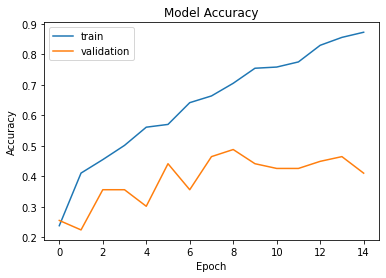

In [464]:
plot_accuracy_history(history_classification_reg)

The training accuracy of the validation and training are both increasing and almost they are parallel, that's good indication.

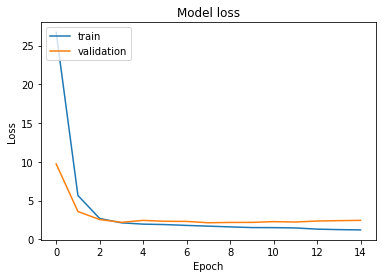

In [465]:
plot_loss_history(history_classification_reg)

The difference in the loss curve between the training and validation is low.

#5 Data Augmentation Classification

---
Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.


In [453]:
from keras.preprocessing.image import ImageDataGenerator

datagen  = ImageDataGenerator(
		rotation_range = 40,
		shear_range = 0.2,
		zoom_range = 0.2,
		horizontal_flip = True,
		rescale=1./255,
		brightness_range = (0.5, 1.5))

datagen.fit(X_train)
datagen.fit(X_valid)

train_generator = datagen.flow(X_train, y_train_k, batch_size=16)
valid_generator = datagen.flow(X_valid, y_valid_k, batch_size=16)

##Model Training

In [454]:
reset_graph(seed=9)

reset_graph(9)
# vgg_model_classification_reg.compile(loss='categorical_crossentropy', 
#                            optimizer='Adam', 
#                            metrics=['accuracy'])

history_classification_augmented= vgg_model_classification_reg.fit_generator(train_generator, epochs=20, verbose=1,  
                                                                             validation_data=(valid_generator)
                                                                             )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
49/49 [==============================] - 3s 49ms/step - loss: 2.4633 - accuracy: 0.5149 - val_loss: 2.4129 - val_accuracy: 0.4419
Epoch 2/20
49/49 [==============================] - 2s 42ms/step - loss: 2.0585 - accuracy: 0.5396 - val_loss: 2.0992 - val_accuracy: 0.4574
Epoch 3/20
49/49 [==============================] - 2s 42ms/step - loss: 1.7548 - accuracy: 0.5888 - val_loss: 2.0819 - val_accuracy: 0.4729
Epoch 4/20
49/49 [==============================] - 2s 43ms/step - loss: 1.7247 - accuracy: 0.5914 - val_loss: 1.9507 - val_accuracy: 0.4651
Epoch 5/20
49/49 [==============================] - 2s 42ms/step - loss: 1.7199 - accuracy: 0.5914 - val_loss: 2.0135 - val_accuracy: 0.4264
Epoch 6/20
49/49 [==============================] - 2s 42ms/step - loss: 1.7008 - accuracy: 0.5863 - val_loss: 1.9379 - val_accuracy: 0.3953
Epoch 7/20
49/49 [==============================] - 2s 42ms/step - loss: 1.5859 - accuracy: 0.6122 - val_loss: 1.8955 - val_accuracy: 0.4186
Epoch 8/20
49

In [455]:
#training
classification_trainpredict_prob_aug = vgg_model_classification_reg .predict(X_train)
clasification_train_pred_aug = classification_trainpredict_prob_aug .argmax(axis=-1)
#validation
classification_validpredict_prob_aug = vgg_model_classification_reg .predict(X_valid)
clasification_valid_pred_aug  = classification_validpredict_prob_aug .argmax(axis=-1)
#testing
classification_testpredict_prob_aug  = vgg_model_classification_reg .predict(X_test)
clasification_test_pred_aug  = classification_testpredict_prob_aug .argmax(axis=-1)

##Evaluation Metrics

**Classification Report**

In [456]:
print("Classification Report of Training data:\n\n",classification_report(y_train_class,clasification_train_pred_aug ))

Classification Report of Training data:

               precision    recall  f1-score   support

           0       0.87      0.93      0.90       168
           1       0.63      0.84      0.72       152
           2       0.74      0.23      0.35       147
           3       0.71      0.24      0.36       155
           4       0.49      0.96      0.65       149

    accuracy                           0.64       771
   macro avg       0.69      0.64      0.59       771
weighted avg       0.69      0.64      0.60       771



In [457]:
print("Classification Report of Validation data:\n\n",classification_report(y_valid_class,clasification_valid_pred_aug ))

Classification Report of Validation data:

               precision    recall  f1-score   support

           0       0.71      1.00      0.83        12
           1       0.47      0.64      0.55        28
           2       0.00      0.00      0.00        33
           3       0.60      0.24      0.34        25
           4       0.52      0.94      0.67        31

    accuracy                           0.50       129
   macro avg       0.46      0.56      0.48       129
weighted avg       0.41      0.50      0.42       129



In [458]:
print("Classification Report of testing data:\n\n",classification_report(y_test_class,clasification_test_pred_aug ))

Classification Report of testing data:

               precision    recall  f1-score   support

           0       0.72      0.90      0.80        20
           1       0.54      0.70      0.61        20
           2       0.67      0.20      0.31        20
           3       0.80      0.20      0.32        20
           4       0.47      0.90      0.62        20

    accuracy                           0.58       100
   macro avg       0.64      0.58      0.53       100
weighted avg       0.64      0.58      0.53       100



**Confusion matrix**

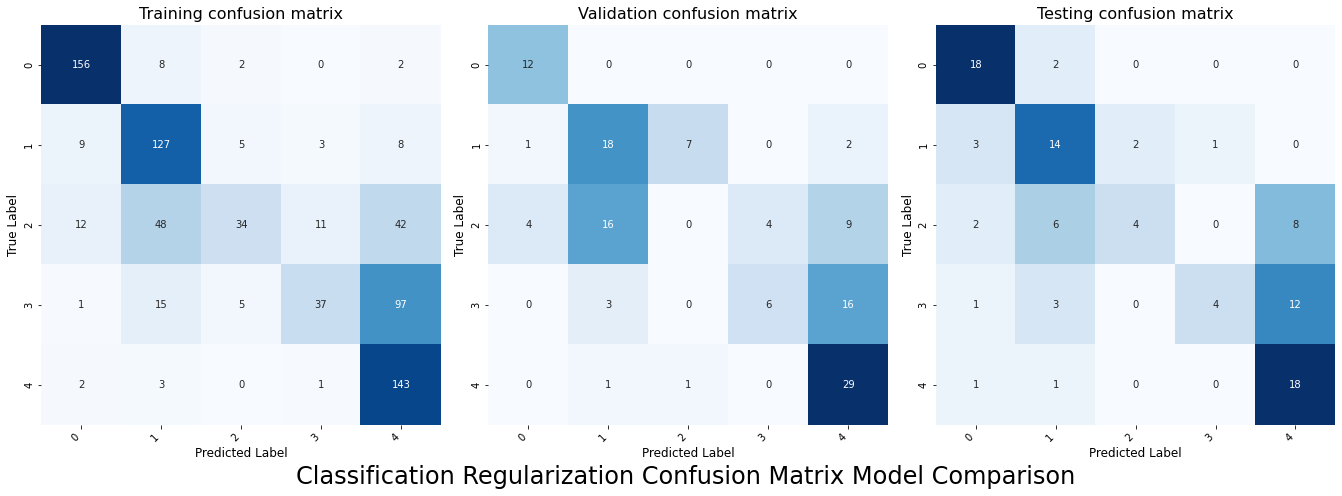

In [459]:
fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 5))

plot_heatmap(y_train_class,clasification_train_pred_aug ,[0,1,2,3,4], ax1, title="Training confusion matrix")  
plot_heatmap(y_valid_class,clasification_valid_pred_aug ,[0,1,2,3,4], ax2, title="Validation confusion matrix")    
plot_heatmap(y_test_class,clasification_test_pred_aug ,[0,1,2,3,4], ax3, title="Testing confusion matrix")   

fig.suptitle("Classification Regularization Confusion Matrix Model Comparison", fontsize=24)
fig. tight_layout(pad=7.0)
fig.subplots_adjust(top=3.00)
plt.show()

**History Visualization**

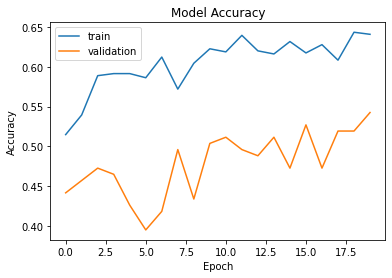

In [462]:
plot_accuracy_history(history_classification_augmented)

**Loss**
Source: Keras manual

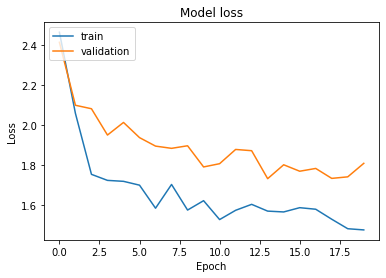

In [463]:
plot_loss_history( history_classification_augmented)

# 5.1 Discussion

Based on the accuracy metrics since our dataset is balanced

Training accuracy:

*   Basic model: 97%
*   Regularized model:88%
*   Regularized with augmentation: 64%

Validation accuracy:

*   Basic model: 38%
*   Regularized model:41%
*   Regularized with augmentation: 50%

Testing accuracy:

*   Basic model: 39%
*   Regularized model:48%
*   Regularized with augmentation: 58%


As we can see, the training accuracy of the model training accuracy decreases tfrom 97% to 88% and the validation and testing accuracies increases as well when we did regularization and that indications that the model overfitting decreases.

When we used the same regularized model but trained it on the augmented images, the training accuracy dropped again because the task is now a little it harder, however, the model performance on the validation data increases from 41% to 50% and on the testing data increases from48% to 58% and that's mean our model now is able to generalize more.

Maybe to improve the performance better than that, we may need to increase the convolutions layer or decrease the batch size.




Based on Learning curves 

1) Basic Calssification model

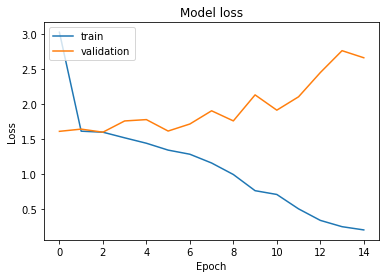

Regularization

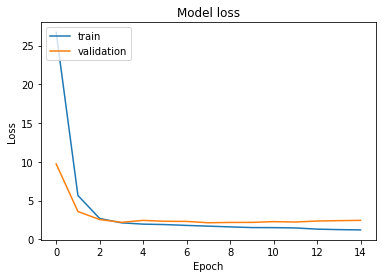

Regularization with augmented images:

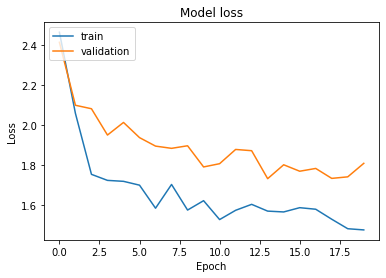


As we notice from the three graphs
basic model that model was higly overfitting, when we made regularization the training loss decreases sharply, however the validation loss is almost constant and finally training the images with augmented images was the best since both training and validation curves are parallel and decreasing.